<a href="https://colab.research.google.com/github/AI4Finance-LLC/FinRL-Library/blob/master/FinRL_multiple_stock_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [ ]:
# ## install finrl library
# !pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_stocktrading import StockTradingEnv
from finrl.model.models import DRLAgent,DRLEnsembleAgent
from finrl.trade.backtest import BackTestStats, BaselineStats, BackTestPlot

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [4]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [5]:
# from config.py start_date is a string
config.START_DATE

'2000-01-01'

In [6]:
print(config.SRI_KEHATI_TICKER)

['AALI.JK', 'ADHI.JK', 'ASII.JK', 'BBCA.JK', 'BBNI.JK', 'BBRI.JK', 'BBTN.JK', 'BMRI.JK', 'BSDE.JK', 'INDF.JK', 'JPFA.JK', 'JSMR.JK', 'KLBF.JK', 'PGAS.JK', 'PJAA.JK', 'PPRO.JK', 'SIDO.JK', 'SMGR.JK', 'TINS.JK', 'TLKM.JK', 'UNTR.JK', 'UNVR.JK', 'WIKA.JK', 'WSKT.JK', 'WTON.JK']


In [7]:
df = YahooDownloader(start_date = config.START_DATE,
                     end_date = '2021-01-19',
                     ticker_list = config.SRI_KEHATI_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [8]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2000-09-05,455.351990,455.351990,441.553986,266.565033,3712344.0,UNTR.JK,1
1,2000-09-06,441.553986,464.552002,436.954010,269.284821,6793100.0,UNTR.JK,2
2,2000-09-07,450.752991,459.951996,446.153015,269.284821,5011393.0,UNTR.JK,3
3,2000-09-08,450.752991,455.351990,446.153015,266.565033,2277955.0,UNTR.JK,4
4,2000-09-11,441.553986,441.553986,427.755005,255.684875,978363.0,UNTR.JK,0


In [9]:
df.tail()

,date,open,high,low,close,volume,tic,day
92689,2021-01-18,26300.0,26850.0,25950.0,26700.0,4282500.0,UNTR.JK,0
92690,2021-01-18,6950.0,7525.0,6900.0,7500.0,44943900.0,UNVR.JK,0
92691,2021-01-18,2410.0,2450.0,2220.0,2250.0,234257600.0,WIKA.JK,0
92692,2021-01-18,1960.0,2080.0,1905.0,1920.0,727533400.0,WSKT.JK,0
92693,2021-01-18,430.0,525.0,430.0,450.0,418011900.0,WTON.JK,0


In [10]:
df.shape

(92694, 8)

In [11]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2000-09-05,455.351990,455.351990,441.553986,266.565033,3712344.0,UNTR.JK,1
1,2000-09-06,441.553986,464.552002,436.954010,269.284821,6793100.0,UNTR.JK,2
2,2000-09-07,450.752991,459.951996,446.153015,269.284821,5011393.0,UNTR.JK,3
3,2000-09-08,450.752991,455.351990,446.153015,266.565033,2277955.0,UNTR.JK,4
4,2000-09-11,441.553986,441.553986,427.755005,255.684875,978363.0,UNTR.JK,0


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [12]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


In [13]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [14]:
processed_full.sample(5)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
162406,2018-06-19,BMRI.JK,6950.000000,6950.000000,6950.00000,6408.632812,0.0,1.0,-73.885197,5749.483119,5065.588414,45.006104,-15.139464,6.759148,5536.032666,5844.029118,0.088732
48915,2006-01-13,SMGR.JK,1980.000000,2010.000000,1980.00000,920.721130,2165000.0,4.0,-0.464230,317.536346,253.201218,54.011935,3.365310,7.897184,287.093089,276.979535,10.552925
36453,2004-09-02,JPFA.JK,39.000000,39.000000,34.00000,15.950438,0.0,3.0,62.406856,1438.484387,1071.852808,61.834484,136.335470,47.312038,1219.007263,1153.802943,1.176868
85244,2010-01-05,BBTN.JK,807.497986,817.111023,797.88501,654.591553,39935197.0,1.0,-93.445048,12551.882930,11932.725078,45.776714,-63.198131,5.239607,12302.148307,12496.153890,6.265504
122724,2014-02-12,PPRO.JK,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [15]:
config.TECHNICAL_INDICATORS_LIST

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [16]:
stock_dimension = len(processed_full.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 25, State Space: 251


In [17]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 50_000_000/100, #Since in Indonesia the minimum number of shares per trx is 100, then we scaled the initial amount by dividing it with 100 
    "buy_cost_pct": 0.0019, #IPOT has 0.19% buy cost
    "sell_cost_pct": 0.0029, #IPOT has 0.29% sell cost
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [18]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)
train_start = '2000-01-01'
train_end = '2019-01-01'
val_test_start = '2019-01-01'
val_test_end = '2021-01-18'

ensemble_agent = DRLEnsembleAgent(df=processed_full,
                 train_period=(train_start,train_end),
                 val_test_period=(val_test_start,val_test_end),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)

In [19]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.01,
                    'learning_rate': 0.0005
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      "action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 50_000,
                      "learning_rate": 0.000005,
                      "batch_size": 128
                    }

timesteps_dict = {'a2c' : 100_000, 
                 'ppo' : 100_000, 
                 'ddpg' : 50_000
                 }

In [ ]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
nan
turbulence_threshold:  5625265.115256409
======Model training from:  2000-01-01 to  2019-01-02
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
Logging to tensorboard_log/a2c/a2c_126_1
------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 100      |
|    time_elapsed       | 5        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -35.6    |
|    explained_variance | 0.229    |
|    learning_rate      | 0.0005   |
|    n_updates          | 99       |
|    policy_loss        | -77      |
|    std                | 1        |
|    value_loss         | 4.79     |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 99        |
|    iterations         | 200       |
|  

------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 1500     |
|    time_elapsed       | 75       |
|    total_timesteps    | 7500     |
| train/                |          |
|    entropy_loss       | -35.6    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 1499     |
|    policy_loss        | -176     |
|    std                | 1        |
|    value_loss         | 33.1     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 1600     |
|    time_elapsed       | 80       |
|    total_timesteps    | 8000     |
| train/                |          |
|    entropy_loss       | -35.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 1599     |
|    policy_loss        | -24.8    |
|

------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 2900     |
|    time_elapsed       | 145      |
|    total_timesteps    | 14500    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | -0.17    |
|    learning_rate      | 0.0005   |
|    n_updates          | 2899     |
|    policy_loss        | -32.9    |
|    std                | 1.01     |
|    value_loss         | 1.59     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 3000     |
|    time_elapsed       | 150      |
|    total_timesteps    | 15000    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | -0.412   |
|    learning_rate      | 0.0005   |
|    n_updates          | 2999     |
|    policy_loss        | -112     |
|

-------------------------------------
| time/                 |           |
|    fps                | 99        |
|    iterations         | 4400      |
|    time_elapsed       | 221       |
|    total_timesteps    | 22000     |
| train/                |           |
|    entropy_loss       | -35.8     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 4399      |
|    policy_loss        | -2.06e+03 |
|    std                | 1.01      |
|    value_loss         | 3.85e+03  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 4500     |
|    time_elapsed       | 226      |
|    total_timesteps    | 22500    |
| train/                |          |
|    entropy_loss       | -35.8    |
|    explained_variance | -0.00306 |
|    learning_rate      | 0.0005   |
|    n_updates          | 4499     |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 5800     |
|    time_elapsed       | 291      |
|    total_timesteps    | 29000    |
| train/                |          |
|    entropy_loss       | -35.8    |
|    explained_variance | 0.00796  |
|    learning_rate      | 0.0005   |
|    n_updates          | 5799     |
|    policy_loss        | -945     |
|    std                | 1.01     |
|    value_loss         | 1.04e+03 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 5900     |
|    time_elapsed       | 296      |
|    total_timesteps    | 29500    |
| train/                |          |
|    entropy_loss       | -35.8    |
|    explained_variance | -0.00384 |
|    learning_rate      | 0.0005   |
|    n_updates          | 5899     |
|    policy_loss        | 6.92e+03 |
|

------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 7300     |
|    time_elapsed       | 367      |
|    total_timesteps    | 36500    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 7299     |
|    policy_loss        | 3.2e+03  |
|    std                | 1.02     |
|    value_loss         | 1.44e+04 |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 2.96e+07 |
|    total_cost         | 5.61e+05 |
|    total_reward       | 2.91e+07 |
|    total_reward_pct   | 5.82e+03 |
|    total_trades       | 37286    |
| time/                 |          |
|    fps                | 99       |
|    iterations         | 7400     |
|    time_elapsed       | 372      |
|    total_timesteps    | 37000    |
|

-------------------------------------
| time/                 |           |
|    fps                | 99        |
|    iterations         | 8700      |
|    time_elapsed       | 437       |
|    total_timesteps    | 43500     |
| train/                |           |
|    entropy_loss       | -35.8     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 8699      |
|    policy_loss        | 1.87e+03  |
|    std                | 1.02      |
|    value_loss         | 4.61e+03  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 8800     |
|    time_elapsed       | 442      |
|    total_timesteps    | 44000    |
| train/                |          |
|    entropy_loss       | -35.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 8799     |
|    policy_loss       

------------------------------------
| environment/          |          |
|    portfolio_value    | 3.76e+07 |
|    total_cost         | 4.07e+05 |
|    total_reward       | 3.71e+07 |
|    total_reward_pct   | 7.43e+03 |
|    total_trades       | 34596    |
| time/                 |          |
|    fps                | 99       |
|    iterations         | 10100    |
|    time_elapsed       | 508      |
|    total_timesteps    | 50500    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | 0.125    |
|    learning_rate      | 0.0005   |
|    n_updates          | 10099    |
|    policy_loss        | -3.73    |
|    std                | 1.02     |
|    value_loss         | 2.63     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 10200    |
|    time_elapsed       | 513      |
|    total_timesteps    | 51000    |
|

------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 11500    |
|    time_elapsed       | 579      |
|    total_timesteps    | 57500    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 11499    |
|    policy_loss        | 1.3e+03  |
|    std                | 1.02     |
|    value_loss         | 1.86e+03 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 99        |
|    iterations         | 11600     |
|    time_elapsed       | 584       |
|    total_timesteps    | 58000     |
| train/                |           |
|    entropy_loss       | -36       |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 11599     |
|    policy_loss        | 7

------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 13000    |
|    time_elapsed       | 655      |
|    total_timesteps    | 65000    |
| train/                |          |
|    entropy_loss       | -36.1    |
|    explained_variance | -0.314   |
|    learning_rate      | 0.0005   |
|    n_updates          | 12999    |
|    policy_loss        | 282      |
|    std                | 1.03     |
|    value_loss         | 65.8     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 13100    |
|    time_elapsed       | 660      |
|    total_timesteps    | 65500    |
| train/                |          |
|    entropy_loss       | -36.1    |
|    explained_variance | -0.00461 |
|    learning_rate      | 0.0005   |
|    n_updates          | 13099    |
|    policy_loss        | 169      |
|

-------------------------------------
| time/                 |           |
|    fps                | 99        |
|    iterations         | 14400     |
|    time_elapsed       | 725       |
|    total_timesteps    | 72000     |
| train/                |           |
|    entropy_loss       | -36       |
|    explained_variance | -0.000486 |
|    learning_rate      | 0.0005    |
|    n_updates          | 14399     |
|    policy_loss        | -2.47e+03 |
|    std                | 1.02      |
|    value_loss         | 4.58e+03  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 14500    |
|    time_elapsed       | 730      |
|    total_timesteps    | 72500    |
| train/                |          |
|    entropy_loss       | -36      |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 14499    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 15800    |
|    time_elapsed       | 796      |
|    total_timesteps    | 79000    |
| train/                |          |
|    entropy_loss       | -36      |
|    explained_variance | 0.126    |
|    learning_rate      | 0.0005   |
|    n_updates          | 15799    |
|    policy_loss        | -183     |
|    std                | 1.03     |
|    value_loss         | 24.8     |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 99        |
|    iterations         | 15900     |
|    time_elapsed       | 801       |
|    total_timesteps    | 79500     |
| train/                |           |
|    entropy_loss       | -36.1     |
|    explained_variance | 0.00854   |
|    learning_rate      | 0.0005    |
|    n_updates          | 15899     |
|    policy_loss        | -

------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 17300    |
|    time_elapsed       | 872      |
|    total_timesteps    | 86500    |
| train/                |          |
|    entropy_loss       | -36      |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 17299    |
|    policy_loss        | 1.28e+03 |
|    std                | 1.03     |
|    value_loss         | 1.23e+03 |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 2.02e+07 |
|    total_cost         | 2.67e+05 |
|    total_reward       | 1.97e+07 |
|    total_reward_pct   | 3.93e+03 |
|    total_trades       | 31457    |
| time/                 |          |
|    fps                | 99       |
|    iterations         | 17400    |
|    time_elapsed       | 877      |
|    total_timesteps    | 87000    |
|

------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 18700    |
|    time_elapsed       | 942      |
|    total_timesteps    | 93500    |
| train/                |          |
|    entropy_loss       | -36      |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 18699    |
|    policy_loss        | -947     |
|    std                | 1.03     |
|    value_loss         | 3.23e+03 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 18800    |
|    time_elapsed       | 947      |
|    total_timesteps    | 94000    |
| train/                |          |
|    entropy_loss       | -36.1    |
|    explained_variance | -0.465   |
|    learning_rate      | 0.0005   |
|    n_updates          | 18799    |
|    policy_loss        | 109      |
|

-----------------------------
| time/              |      |
|    fps             | 108  |
|    iterations      | 1    |
|    time_elapsed    | 18   |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 106        |
|    iterations           | 2          |
|    time_elapsed         | 38         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01813078 |
|    clip_fraction        | 0.174      |
|    clip_range           | 0.2        |
|    entropy_loss         | -35.5      |
|    explained_variance   | 0.00997    |
|    learning_rate        | 0.00025    |
|    loss                 | 18.3       |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0288    |
|    std                  | 1          |
|    value_loss           | 57.5       |
----------------------------------------
-----------

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 11          |
|    time_elapsed         | 215         |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.017748863 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | -35.7       |
|    explained_variance   | 0.112       |
|    learning_rate        | 0.00025     |
|    loss                 | 26.5        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.0171     |
|    std                  | 1.01        |
|    value_loss           | 94.7        |
-----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.54e+05    |
|    total_cost           | 6.19e+06    |
|    total_reward         | -2.46e

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 20          |
|    time_elapsed         | 391         |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.020654386 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -35.9       |
|    explained_variance   | 0.0661      |
|    learning_rate        | 0.00025     |
|    loss                 | 113         |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.0158     |
|    std                  | 1.02        |
|    value_loss           | 192         |
-----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | -5.43e+05   |
|    total_cost           | 1.42e+06    |
|    total_reward         | -1.04e

day: 4572, episode: 35
begin_total_asset: 500000.00
end_total_asset: 1584231.99
total_reward: 1084231.99
total_cost: 7989926.55
total_trades: 61014
Sharpe: 0.343
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.58e+06    |
|    total_cost           | 7.99e+06    |
|    total_reward         | 1.08e+06    |
|    total_reward_pct     | 217         |
|    total_trades         | 61014       |
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 30          |
|    time_elapsed         | 588         |
|    total_timesteps      | 61440       |
| train/                  |             |
|    approx_kl            | 0.013875287 |
|    clip_fraction        | 0.192       |
|    clip_range           | 0.2         |
|    entropy_loss         | -36.2       |
|    explained_variance   | 0.15        |
|    learning_rate        | 0.00025     |
|    loss                 | 75.6        

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 39          |
|    time_elapsed         | 765         |
|    total_timesteps      | 79872       |
| train/                  |             |
|    approx_kl            | 0.008213143 |
|    clip_fraction        | 0.0603      |
|    clip_range           | 0.2         |
|    entropy_loss         | -36.4       |
|    explained_variance   | 0.0168      |
|    learning_rate        | 0.00025     |
|    loss                 | 1.54e+04    |
|    n_updates            | 380         |
|    policy_gradient_loss | -0.00277    |
|    std                  | 1.04        |
|    value_loss           | 1.05e+04    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 40          |
|    time_elapsed         | 784   

----------------------------------------
| time/                   |            |
|    fps                  | 104        |
|    iterations           | 48         |
|    time_elapsed         | 942        |
|    total_timesteps      | 98304      |
| train/                  |            |
|    approx_kl            | 0.02686143 |
|    clip_fraction        | 0.164      |
|    clip_range           | 0.2        |
|    entropy_loss         | -36.6      |
|    explained_variance   | 0.156      |
|    learning_rate        | 0.00025    |
|    loss                 | 247        |
|    n_updates            | 470        |
|    policy_gradient_loss | -0.00648   |
|    std                  | 1.05       |
|    value_loss           | 440        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 49          |
|    time_elapsed         | 961         |
|    total_

------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 500      |
|    time_elapsed       | 25       |
|    total_timesteps    | 2500     |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | 0.0972   |
|    learning_rate      | 0.0005   |
|    n_updates          | 499      |
|    policy_loss        | 132      |
|    std                | 1.01     |
|    value_loss         | 186      |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 97        |
|    iterations         | 600       |
|    time_elapsed       | 30        |
|    total_timesteps    | 3000      |
| train/                |           |
|    entropy_loss       | -35.6     |
|    explained_variance | -0.0793   |
|    learning_rate      | 0.0005    |
|    n_updates          | 599       |
|    policy_loss        | -

------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 2000     |
|    time_elapsed       | 101      |
|    total_timesteps    | 10000    |
| train/                |          |
|    entropy_loss       | -35.6    |
|    explained_variance | -0.548   |
|    learning_rate      | 0.0005   |
|    n_updates          | 1999     |
|    policy_loss        | -39.5    |
|    std                | 1.01     |
|    value_loss         | 3.64     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 2100     |
|    time_elapsed       | 107      |
|    total_timesteps    | 10500    |
| train/                |          |
|    entropy_loss       | -35.6    |
|    explained_variance | -0.00373 |
|    learning_rate      | 0.0005   |
|    n_updates          | 2099     |
|    policy_loss        | 74.7     |
|

------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 3500     |
|    time_elapsed       | 178      |
|    total_timesteps    | 17500    |
| train/                |          |
|    entropy_loss       | -35.5    |
|    explained_variance | 0.00146  |
|    learning_rate      | 0.0005   |
|    n_updates          | 3499     |
|    policy_loss        | -80.1    |
|    std                | 1        |
|    value_loss         | 238      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 3600     |
|    time_elapsed       | 183      |
|    total_timesteps    | 18000    |
| train/                |          |
|    entropy_loss       | -35.5    |
|    explained_variance | 0.00493  |
|    learning_rate      | 0.0005   |
|    n_updates          | 3599     |
|    policy_loss        | 260      |
|

------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 4900     |
|    time_elapsed       | 249      |
|    total_timesteps    | 24500    |
| train/                |          |
|    entropy_loss       | -35.5    |
|    explained_variance | 0.0877   |
|    learning_rate      | 0.0005   |
|    n_updates          | 4899     |
|    policy_loss        | -201     |
|    std                | 1        |
|    value_loss         | 43.6     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 5000     |
|    time_elapsed       | 254      |
|    total_timesteps    | 25000    |
| train/                |          |
|    entropy_loss       | -35.5    |
|    explained_variance | 2.44e-06 |
|    learning_rate      | 0.0005   |
|    n_updates          | 4999     |
|    policy_loss        | 958      |
|

------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 6400     |
|    time_elapsed       | 325      |
|    total_timesteps    | 32000    |
| train/                |          |
|    entropy_loss       | -35.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 6399     |
|    policy_loss        | -19.6    |
|    std                | 1        |
|    value_loss         | 0.405    |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 6.66e+07 |
|    total_cost         | 1.53e+05 |
|    total_reward       | 6.61e+07 |
|    total_reward_pct   | 1.32e+04 |
|    total_trades       | 41479    |
| time/                 |          |
|    fps                | 98       |
|    iterations         | 6500     |
|    time_elapsed       | 330      |
|    total_timesteps    | 32500    |
|

------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 7800     |
|    time_elapsed       | 397      |
|    total_timesteps    | 39000    |
| train/                |          |
|    entropy_loss       | -35.6    |
|    explained_variance | -0.00769 |
|    learning_rate      | 0.0005   |
|    n_updates          | 7799     |
|    policy_loss        | 3e+03    |
|    std                | 1        |
|    value_loss         | 1.09e+04 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 98        |
|    iterations         | 7900      |
|    time_elapsed       | 402       |
|    total_timesteps    | 39500     |
| train/                |           |
|    entropy_loss       | -35.6     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 7899      |
|    policy_loss        | -

day: 4635, episode: 10
begin_total_asset: 500000.00
end_total_asset: -7373126.51
total_reward: -7873126.51
total_cost: 475706.10
total_trades: 45224
Sharpe: -0.233
-------------------------------------
| environment/          |           |
|    portfolio_value    | -7.37e+06 |
|    total_cost         | 4.76e+05  |
|    total_reward       | -7.87e+06 |
|    total_reward_pct   | -1.57e+03 |
|    total_trades       | 45224     |
| time/                 |           |
|    fps                | 98        |
|    iterations         | 9300      |
|    time_elapsed       | 473       |
|    total_timesteps    | 46500     |
| train/                |           |
|    entropy_loss       | -35.6     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 9299      |
|    policy_loss        | -88.2     |
|    std                | 1.01      |
|    value_loss         | 9.36      |
-------------------------------------
-------------------------------------


------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 10700    |
|    time_elapsed       | 545      |
|    total_timesteps    | 53500    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | 0.000498 |
|    learning_rate      | 0.0005   |
|    n_updates          | 10699    |
|    policy_loss        | 1.06e+03 |
|    std                | 1.01     |
|    value_loss         | 1.23e+03 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 10800    |
|    time_elapsed       | 550      |
|    total_timesteps    | 54000    |
| train/                |          |
|    entropy_loss       | -35.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 10799    |
|    policy_loss        | 1.59e+03 |
|

------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 12200    |
|    time_elapsed       | 621      |
|    total_timesteps    | 61000    |
| train/                |          |
|    entropy_loss       | -35.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 12199    |
|    policy_loss        | -224     |
|    std                | 1.01     |
|    value_loss         | 45.6     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 12300    |
|    time_elapsed       | 626      |
|    total_timesteps    | 61500    |
| train/                |          |
|    entropy_loss       | -35.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 12299    |
|    policy_loss        | -64.1    |
|

------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 13700    |
|    time_elapsed       | 698      |
|    total_timesteps    | 68500    |
| train/                |          |
|    entropy_loss       | -35.5    |
|    explained_variance | 0.00115  |
|    learning_rate      | 0.0005   |
|    n_updates          | 13699    |
|    policy_loss        | -148     |
|    std                | 1        |
|    value_loss         | 128      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 13800    |
|    time_elapsed       | 703      |
|    total_timesteps    | 69000    |
| train/                |          |
|    entropy_loss       | -35.5    |
|    explained_variance | 0.00258  |
|    learning_rate      | 0.0005   |
|    n_updates          | 13799    |
|    policy_loss        | -192     |
|

------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 15100    |
|    time_elapsed       | 769      |
|    total_timesteps    | 75500    |
| train/                |          |
|    entropy_loss       | -35.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 15099    |
|    policy_loss        | 170      |
|    std                | 1.01     |
|    value_loss         | 34       |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 15200    |
|    time_elapsed       | 774      |
|    total_timesteps    | 76000    |
| train/                |          |
|    entropy_loss       | -35.6    |
|    explained_variance | -0.00881 |
|    learning_rate      | 0.0005   |
|    n_updates          | 15199    |
|    policy_loss        | 1.45e+03 |
|

-------------------------------------
| time/                 |           |
|    fps                | 98        |
|    iterations         | 16600     |
|    time_elapsed       | 846       |
|    total_timesteps    | 83000     |
| train/                |           |
|    entropy_loss       | -35.6     |
|    explained_variance | -0.000384 |
|    learning_rate      | 0.0005    |
|    n_updates          | 16599     |
|    policy_loss        | -38.9     |
|    std                | 1.01      |
|    value_loss         | 325       |
-------------------------------------
-------------------------------------
| environment/          |           |
|    portfolio_value    | -3.14e+06 |
|    total_cost         | 6.12e+04  |
|    total_reward       | -3.64e+06 |
|    total_reward_pct   | -728      |
|    total_trades       | 52448     |
| time/                 |           |
|    fps                | 98        |
|    iterations         | 16700     |
|    time_elapsed       | 851       |
|    total_t

------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 18000    |
|    time_elapsed       | 918      |
|    total_timesteps    | 90000    |
| train/                |          |
|    entropy_loss       | -35.6    |
|    explained_variance | 0.000417 |
|    learning_rate      | 0.0005   |
|    n_updates          | 17999    |
|    policy_loss        | 2.47e+03 |
|    std                | 1        |
|    value_loss         | 6.37e+03 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 98        |
|    iterations         | 18100     |
|    time_elapsed       | 923       |
|    total_timesteps    | 90500     |
| train/                |           |
|    entropy_loss       | -35.5     |
|    explained_variance | 2.98e-07  |
|    learning_rate      | 0.0005    |
|    n_updates          | 18099     |
|    policy_loss        | -

------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 19400    |
|    time_elapsed       | 989      |
|    total_timesteps    | 97000    |
| train/                |          |
|    entropy_loss       | -35.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 19399    |
|    policy_loss        | 1.23e+03 |
|    std                | 1        |
|    value_loss         | 1.25e+04 |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.24e+08 |
|    total_cost         | 1.3e+05  |
|    total_reward       | 1.24e+08 |
|    total_reward_pct   | 2.48e+04 |
|    total_trades       | 53609    |
| time/                 |          |
|    fps                | 98       |
|    iterations         | 19500    |
|    time_elapsed       | 994      |
|    total_timesteps    | 97500    |
|

----------------------------------------
| time/                   |            |
|    fps                  | 103        |
|    iterations           | 6          |
|    time_elapsed         | 118        |
|    total_timesteps      | 12288      |
| train/                  |            |
|    approx_kl            | 0.02122763 |
|    clip_fraction        | 0.261      |
|    clip_range           | 0.2        |
|    entropy_loss         | -35.7      |
|    explained_variance   | 0.248      |
|    learning_rate        | 0.00025    |
|    loss                 | 10.6       |
|    n_updates            | 50         |
|    policy_gradient_loss | -0.0248    |
|    std                  | 1.01       |
|    value_loss           | 28.2       |
----------------------------------------
day: 4635, episode: 25
begin_total_asset: 500000.00
end_total_asset: 249092.39
total_reward: -250907.61
total_cost: 6161972.75
total_trades: 59136
Sharpe: 0.227
-----------------------------------------
| environment/    

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 15          |
|    time_elapsed         | 297         |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 0.006823021 |
|    clip_fraction        | 0.187       |
|    clip_range           | 0.2         |
|    entropy_loss         | -36.2       |
|    explained_variance   | 0.185       |
|    learning_rate        | 0.00025     |
|    loss                 | 138         |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.0174     |
|    std                  | 1.03        |
|    value_loss           | 227         |
-----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.83e+07    |
|    total_cost           | 1.65e+07    |
|    total_reward         | 1.78e+

------------------------------------------
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 24           |
|    time_elapsed         | 476          |
|    total_timesteps      | 49152        |
| train/                  |              |
|    approx_kl            | 0.0038075643 |
|    clip_fraction        | 0.0688       |
|    clip_range           | 0.2          |
|    entropy_loss         | -36.3        |
|    explained_variance   | 0.0478       |
|    learning_rate        | 0.00025      |
|    loss                 | 2.94e+03     |
|    n_updates            | 230          |
|    policy_gradient_loss | -0.0123      |
|    std                  | 1.03         |
|    value_loss           | 5.81e+03     |
------------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.31e+07    |
|    total_cost           | 2.4e+07     |
|    total_rewa

----------------------------------------
| time/                   |            |
|    fps                  | 103        |
|    iterations           | 33         |
|    time_elapsed         | 655        |
|    total_timesteps      | 67584      |
| train/                  |            |
|    approx_kl            | 0.03435031 |
|    clip_fraction        | 0.21       |
|    clip_range           | 0.2        |
|    entropy_loss         | -36.7      |
|    explained_variance   | 0.365      |
|    learning_rate        | 0.00025    |
|    loss                 | 81.6       |
|    n_updates            | 320        |
|    policy_gradient_loss | -0.0114    |
|    std                  | 1.05       |
|    value_loss           | 132        |
----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.43e+07    |
|    total_cost           | 2.05e+07    |
|    total_reward         | 2.38e+07    |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 42          |
|    time_elapsed         | 834         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.010648734 |
|    clip_fraction        | 0.0353      |
|    clip_range           | 0.2         |
|    entropy_loss         | -36.9       |
|    explained_variance   | 0.0016      |
|    learning_rate        | 0.00025     |
|    loss                 | 6.78e+04    |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.00285    |
|    std                  | 1.06        |
|    value_loss           | 1.44e+05    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 43          |
|    time_elapsed         | 854   

day: 4635, episode: 50
begin_total_asset: 500000.00
end_total_asset: 50874364.54
total_reward: 50374364.54
total_cost: 1184.51
total_trades: 45414
Sharpe: 0.330
----------------------------------
| environment/        |          |
|    portfolio_value  | 5.45e+07 |
|    total_cost       | 3.05e+03 |
|    total_reward     | 5.4e+07  |
|    total_reward_pct | 1.08e+04 |
|    total_trades     | 46657    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 53       |
|    time_elapsed     | 694      |
|    total timesteps  | 37088    |
| train/              |          |
|    actor_loss       | 15.8     |
|    critic_loss      | 3.06e+03 |
|    learning_rate    | 5e-06    |
|    n_updates        | 32452    |
----------------------------------
day: 4635, episode: 55
begin_total_asset: 500000.00
end_total_asset: 53110018.05
total_reward: 52610018.05
total_cost: 1289.64
total_trades: 44705
Sharpe: 0.320
======DDPG Validation from:  2019-04-01 to  2019

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 8.77e+04    |
|    total_cost           | 3.7e+06     |
|    total_reward         | -4.12e+05   |
|    total_reward_pct     | -82.5       |
|    total_trades         | 58389       |
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 10          |
|    time_elapsed         | 199         |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.021699026 |
|    clip_fraction        | 0.267       |
|    clip_range           | 0.2         |
|    entropy_loss         | -35.7       |
|    explained_variance   | 0.227       |
|    learning_rate        | 0.00025     |
|    loss                 | 5.88        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00444    |
|    std                  | 1.01        |
|    value_loss           | 19.2  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1e+05       |
|    total_cost           | 4.37e+06    |
|    total_reward         | -4e+05      |
|    total_reward_pct     | -80         |
|    total_trades         | 59096       |
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 19          |
|    time_elapsed         | 380         |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.020075489 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | -35.9       |
|    explained_variance   | 0.162       |
|    learning_rate        | 0.00025     |
|    loss                 | 25          |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.01       |
|    std                  | 1.02        |
|    value_loss           | 55.4  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.27e+04    |
|    total_cost           | 2.11e+06    |
|    total_reward         | -4.77e+05   |
|    total_reward_pct     | -95.5       |
|    total_trades         | 55905       |
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 28          |
|    time_elapsed         | 561         |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.030743849 |
|    clip_fraction        | 0.291       |
|    clip_range           | 0.2         |
|    entropy_loss         | -36.2       |
|    explained_variance   | 0.309       |
|    learning_rate        | 0.00025     |
|    loss                 | 5.92        |
|    n_updates            | 270         |
|    policy_gradient_loss | -0.0026     |
|    std                  | 1.03        |
|    value_loss           | 14.1  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.85e+06    |
|    total_cost           | 1.19e+07    |
|    total_reward         | 2.35e+06    |
|    total_reward_pct     | 470         |
|    total_trades         | 66080       |
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 37          |
|    time_elapsed         | 742         |
|    total_timesteps      | 75776       |
| train/                  |             |
|    approx_kl            | 0.020789951 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -36.6       |
|    explained_variance   | 0.0883      |
|    learning_rate        | 0.00025     |
|    loss                 | 212         |
|    n_updates            | 360         |
|    policy_gradient_loss | -0.0126     |
|    std                  | 1.05        |
|    value_loss           | 668   

day: 4698, episode: 20
begin_total_asset: 500000.00
end_total_asset: 1099259.40
total_reward: 599259.40
total_cost: 10359394.87
total_trades: 64063
Sharpe: 0.494
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.1e+06     |
|    total_cost           | 1.04e+07    |
|    total_reward         | 5.99e+05    |
|    total_reward_pct     | 120         |
|    total_trades         | 64063       |
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 46          |
|    time_elapsed         | 922         |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.010646532 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -36.7       |
|    explained_variance   | 0.0786      |
|    learning_rate        | 0.00025     |
|    loss                 | 289         

------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 900      |
|    time_elapsed       | 46       |
|    total_timesteps    | 4500     |
| train/                |          |
|    entropy_loss       | -35.6    |
|    explained_variance | -0.0106  |
|    learning_rate      | 0.0005   |
|    n_updates          | 899      |
|    policy_loss        | 245      |
|    std                | 1        |
|    value_loss         | 55       |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 7.03e+06 |
|    total_cost         | 9.55e+06 |
|    total_reward       | 6.53e+06 |
|    total_reward_pct   | 1.31e+03 |
|    total_trades       | 61821    |
| time/                 |          |
|    fps                | 97       |
|    iterations         | 1000     |
|    time_elapsed       | 51       |
|    total_timesteps    | 5000     |
|

------------------------------------
| time/                 |          |
|    fps                | 97       |
|    iterations         | 2300     |
|    time_elapsed       | 118      |
|    total_timesteps    | 11500    |
| train/                |          |
|    entropy_loss       | -35.6    |
|    explained_variance | -0.0176  |
|    learning_rate      | 0.0005   |
|    n_updates          | 2299     |
|    policy_loss        | 907      |
|    std                | 1        |
|    value_loss         | 1.37e+03 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 97       |
|    iterations         | 2400     |
|    time_elapsed       | 123      |
|    total_timesteps    | 12000    |
| train/                |          |
|    entropy_loss       | -35.5    |
|    explained_variance | 0.00452  |
|    learning_rate      | 0.0005   |
|    n_updates          | 2399     |
|    policy_loss        | -464     |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 3.74e+07 |
|    total_cost         | 2.08e+06 |
|    total_reward       | 3.69e+07 |
|    total_reward_pct   | 7.39e+03 |
|    total_trades       | 49670    |
| time/                 |          |
|    fps                | 97       |
|    iterations         | 3800     |
|    time_elapsed       | 195      |
|    total_timesteps    | 19000    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | -0.494   |
|    learning_rate      | 0.0005   |
|    n_updates          | 3799     |
|    policy_loss        | -10.1    |
|    std                | 1.01     |
|    value_loss         | 1.64     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 97       |
|    iterations         | 3900     |
|    time_elapsed       | 200      |
|    total_timesteps    | 19500    |
|

------------------------------------
| time/                 |          |
|    fps                | 97       |
|    iterations         | 5200     |
|    time_elapsed       | 267      |
|    total_timesteps    | 26000    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | 0.00482  |
|    learning_rate      | 0.0005   |
|    n_updates          | 5199     |
|    policy_loss        | 326      |
|    std                | 1.01     |
|    value_loss         | 476      |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 97        |
|    iterations         | 5300      |
|    time_elapsed       | 272       |
|    total_timesteps    | 26500     |
| train/                |           |
|    entropy_loss       | -35.7     |
|    explained_variance | -9.18e-05 |
|    learning_rate      | 0.0005    |
|    n_updates          | 5299      |
|    policy_loss        | -

------------------------------------
| time/                 |          |
|    fps                | 97       |
|    iterations         | 6700     |
|    time_elapsed       | 344      |
|    total_timesteps    | 33500    |
| train/                |          |
|    entropy_loss       | -35.8    |
|    explained_variance | -0.733   |
|    learning_rate      | 0.0005   |
|    n_updates          | 6699     |
|    policy_loss        | -21      |
|    std                | 1.01     |
|    value_loss         | 2.29     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 97       |
|    iterations         | 6800     |
|    time_elapsed       | 349      |
|    total_timesteps    | 34000    |
| train/                |          |
|    entropy_loss       | -35.8    |
|    explained_variance | 0.053    |
|    learning_rate      | 0.0005   |
|    n_updates          | 6799     |
|    policy_loss        | -117     |
|

-------------------------------------
| time/                 |           |
|    fps                | 97        |
|    iterations         | 8200      |
|    time_elapsed       | 421       |
|    total_timesteps    | 41000     |
| train/                |           |
|    entropy_loss       | -35.7     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 8199      |
|    policy_loss        | -1.72e+04 |
|    std                | 1.01      |
|    value_loss         | 2.75e+05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 97        |
|    iterations         | 8300      |
|    time_elapsed       | 426       |
|    total_timesteps    | 41500     |
| train/                |           |
|    entropy_loss       | -35.7     |
|    explained_variance | -0.000222 |
|    learning_rate      | 0.0005    |
|    n_updates          | 8299      |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 97       |
|    iterations         | 9600     |
|    time_elapsed       | 493      |
|    total_timesteps    | 48000    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 9599     |
|    policy_loss        | 41.6     |
|    std                | 1.01     |
|    value_loss         | 3.58     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 97       |
|    iterations         | 9700     |
|    time_elapsed       | 498      |
|    total_timesteps    | 48500    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | 0.00212  |
|    learning_rate      | 0.0005   |
|    n_updates          | 9699     |
|    policy_loss        | -257     |
|

-------------------------------------
| time/                 |           |
|    fps                | 97        |
|    iterations         | 11100     |
|    time_elapsed       | 570       |
|    total_timesteps    | 55500     |
| train/                |           |
|    entropy_loss       | -35.6     |
|    explained_variance | 5.01e-05  |
|    learning_rate      | 0.0005    |
|    n_updates          | 11099     |
|    policy_loss        | -2.92e+03 |
|    std                | 1.01      |
|    value_loss         | 1.41e+04  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 97        |
|    iterations         | 11200     |
|    time_elapsed       | 575       |
|    total_timesteps    | 56000     |
| train/                |           |
|    entropy_loss       | -35.6     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 11199     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 97       |
|    iterations         | 12500    |
|    time_elapsed       | 642      |
|    total_timesteps    | 62500    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | 0.0464   |
|    learning_rate      | 0.0005   |
|    n_updates          | 12499    |
|    policy_loss        | -244     |
|    std                | 1.01     |
|    value_loss         | 83.9     |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 97        |
|    iterations         | 12600     |
|    time_elapsed       | 648       |
|    total_timesteps    | 63000     |
| train/                |           |
|    entropy_loss       | -35.7     |
|    explained_variance | 0.0291    |
|    learning_rate      | 0.0005    |
|    n_updates          | 12599     |
|    policy_loss        | -

------------------------------------
| time/                 |          |
|    fps                | 97       |
|    iterations         | 14000    |
|    time_elapsed       | 720      |
|    total_timesteps    | 70000    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 13999    |
|    policy_loss        | 1.36e+04 |
|    std                | 1.01     |
|    value_loss         | 1.6e+05  |
------------------------------------
day: 4698, episode: 15
begin_total_asset: 500000.00
end_total_asset: 138312706.86
total_reward: 137812706.86
total_cost: 147690.05
total_trades: 52448
Sharpe: 0.235
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.38e+08 |
|    total_cost         | 1.48e+05 |
|    total_reward       | 1.38e+08 |
|    total_reward_pct   | 2.76e+04 |
|    total_trades       | 52448    |
| time/              

------------------------------------
| time/                 |          |
|    fps                | 97       |
|    iterations         | 15400    |
|    time_elapsed       | 793      |
|    total_timesteps    | 77000    |
| train/                |          |
|    entropy_loss       | -35.8    |
|    explained_variance | -0.0122  |
|    learning_rate      | 0.0005   |
|    n_updates          | 15399    |
|    policy_loss        | -342     |
|    std                | 1.02     |
|    value_loss         | 5.48e+03 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 97        |
|    iterations         | 15500     |
|    time_elapsed       | 798       |
|    total_timesteps    | 77500     |
| train/                |           |
|    entropy_loss       | -35.9     |
|    explained_variance | -0.000404 |
|    learning_rate      | 0.0005    |
|    n_updates          | 15499     |
|    policy_loss        | 1

------------------------------------
| time/                 |          |
|    fps                | 97       |
|    iterations         | 16900    |
|    time_elapsed       | 870      |
|    total_timesteps    | 84500    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 16899    |
|    policy_loss        | -3.5e+03 |
|    std                | 1.02     |
|    value_loss         | 2.7e+04  |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 6.37e+07 |
|    total_cost         | 1.88e+05 |
|    total_reward       | 6.32e+07 |
|    total_reward_pct   | 1.26e+04 |
|    total_trades       | 48423    |
| time/                 |          |
|    fps                | 97       |
|    iterations         | 17000    |
|    time_elapsed       | 875      |
|    total_timesteps    | 85000    |
|

------------------------------------
| time/                 |          |
|    fps                | 97       |
|    iterations         | 18300    |
|    time_elapsed       | 942      |
|    total_timesteps    | 91500    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | 0.00149  |
|    learning_rate      | 0.0005   |
|    n_updates          | 18299    |
|    policy_loss        | 2.28e+03 |
|    std                | 1.02     |
|    value_loss         | 6.88e+03 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 97        |
|    iterations         | 18400     |
|    time_elapsed       | 948       |
|    total_timesteps    | 92000     |
| train/                |           |
|    entropy_loss       | -35.9     |
|    explained_variance | -0.000308 |
|    learning_rate      | 0.0005    |
|    n_updates          | 18399     |
|    policy_loss        | 3

-------------------------------------
| time/                 |           |
|    fps                | 97        |
|    iterations         | 19700     |
|    time_elapsed       | 1015      |
|    total_timesteps    | 98500     |
| train/                |           |
|    entropy_loss       | -35.9     |
|    explained_variance | 5.96e-08  |
|    learning_rate      | 0.0005    |
|    n_updates          | 19699     |
|    policy_loss        | -2.32e+03 |
|    std                | 1.02      |
|    value_loss         | 5.65e+03  |
-------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 5.24e+07 |
|    total_cost         | 9.57e+04 |
|    total_reward       | 5.19e+07 |
|    total_reward_pct   | 1.04e+04 |
|    total_trades       | 51907    |
| time/                 |          |
|    fps                | 97       |
|    iterations         | 19800    |
|    time_elapsed       | 1020     |
|    total_timesteps   

-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 8           |
|    time_elapsed         | 159         |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.029916165 |
|    clip_fraction        | 0.306       |
|    clip_range           | 0.2         |
|    entropy_loss         | -35.7       |
|    explained_variance   | 0.357       |
|    learning_rate        | 0.00025     |
|    loss                 | 1.4         |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.0153     |
|    std                  | 1.01        |
|    value_loss           | 4.2         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 9           |
|    time_elapsed         | 179   

-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 18          |
|    time_elapsed         | 360         |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.010163548 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -35.9       |
|    explained_variance   | 0.298       |
|    learning_rate        | 0.00025     |
|    loss                 | 71.1        |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.012      |
|    std                  | 1.02        |
|    value_loss           | 104         |
-----------------------------------------
day: 4698, episode: 30
begin_total_asset: 500000.00
end_total_asset: 1133654.94
total_reward: 633654.94
total_cost: 9592088.10
total_trades: 63769
Sharpe: 0.235
-----------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 27          |
|    time_elapsed         | 541         |
|    total_timesteps      | 55296       |
| train/                  |             |
|    approx_kl            | 0.014180556 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -36.2       |
|    explained_variance   | 0.463       |
|    learning_rate        | 0.00025     |
|    loss                 | 59.2        |
|    n_updates            | 260         |
|    policy_gradient_loss | -0.0135     |
|    std                  | 1.03        |
|    value_loss           | 117         |
-----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.33e+07    |
|    total_cost           | 1.6e+07     |
|    total_reward         | 1.28e+

-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 36          |
|    time_elapsed         | 722         |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.005908137 |
|    clip_fraction        | 0.0408      |
|    clip_range           | 0.2         |
|    entropy_loss         | -36.3       |
|    explained_variance   | 0.0242      |
|    learning_rate        | 0.00025     |
|    loss                 | 3.59e+03    |
|    n_updates            | 350         |
|    policy_gradient_loss | -0.00936    |
|    std                  | 1.03        |
|    value_loss           | 1.29e+04    |
-----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 7.41e+05    |
|    total_cost           | 8.59e+06    |
|    total_reward         | 2.41e+

------------------------------------------
| time/                   |              |
|    fps                  | 101          |
|    iterations           | 45           |
|    time_elapsed         | 903          |
|    total_timesteps      | 92160        |
| train/                  |              |
|    approx_kl            | 0.0077820765 |
|    clip_fraction        | 0.0282       |
|    clip_range           | 0.2          |
|    entropy_loss         | -36.5        |
|    explained_variance   | 0.0312       |
|    learning_rate        | 0.00025      |
|    loss                 | 6.64e+03     |
|    n_updates            | 440          |
|    policy_gradient_loss | -0.00901     |
|    std                  | 1.04         |
|    value_loss           | 1.48e+04     |
------------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | -8.17e+06   |
|    total_cost           | 1.67e+06    |
|    total_rewa

------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 300      |
|    time_elapsed       | 15       |
|    total_timesteps    | 1500     |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | -0.0805  |
|    learning_rate      | 0.0005   |
|    n_updates          | 299      |
|    policy_loss        | 218      |
|    std                | 1.02     |
|    value_loss         | 65.9     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 400      |
|    time_elapsed       | 20       |
|    total_timesteps    | 2000     |
| train/                |          |
|    entropy_loss       | -35.8    |
|    explained_variance | 0.0193   |
|    learning_rate      | 0.0005   |
|    n_updates          | 399      |
|    policy_loss        | 741      |
|

------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 1800     |
|    time_elapsed       | 93       |
|    total_timesteps    | 9000     |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | 0.064    |
|    learning_rate      | 0.0005   |
|    n_updates          | 1799     |
|    policy_loss        | -143     |
|    std                | 1.02     |
|    value_loss         | 23.5     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 1900     |
|    time_elapsed       | 98       |
|    total_timesteps    | 9500     |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | 0.00593  |
|    learning_rate      | 0.0005   |
|    n_updates          | 1899     |
|    policy_loss        | -683     |
|

------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 3200     |
|    time_elapsed       | 166      |
|    total_timesteps    | 16000    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | 0.176    |
|    learning_rate      | 0.0005   |
|    n_updates          | 3199     |
|    policy_loss        | -304     |
|    std                | 1.02     |
|    value_loss         | 83.2     |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 3300      |
|    time_elapsed       | 172       |
|    total_timesteps    | 16500     |
| train/                |           |
|    entropy_loss       | -35.9     |
|    explained_variance | -0.0462   |
|    learning_rate      | 0.0005    |
|    n_updates          | 3299      |
|    policy_loss        | -

------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 4700     |
|    time_elapsed       | 244      |
|    total_timesteps    | 23500    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 4699     |
|    policy_loss        | 1.35e+04 |
|    std                | 1.02     |
|    value_loss         | 1.9e+05  |
------------------------------------
day: 4761, episode: 5
begin_total_asset: 500000.00
end_total_asset: 206570244.53
total_reward: 206070244.53
total_cost: 3648642.64
total_trades: 51778
Sharpe: -0.154
------------------------------------
| environment/          |          |
|    portfolio_value    | 2.07e+08 |
|    total_cost         | 3.65e+06 |
|    total_reward       | 2.06e+08 |
|    total_reward_pct   | 4.12e+04 |
|    total_trades       | 51778    |
| time/             

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 6100      |
|    time_elapsed       | 317       |
|    total_timesteps    | 30500     |
| train/                |           |
|    entropy_loss       | -35.8     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 6099      |
|    policy_loss        | 2.44e+03  |
|    std                | 1.01      |
|    value_loss         | 5.52e+03  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 6200      |
|    time_elapsed       | 322       |
|    total_timesteps    | 31000     |
| train/                |           |
|    entropy_loss       | -35.7     |
|    explained_variance | -0.000216 |
|    learning_rate      | 0.0005    |
|    n_updates          | 6199      |
|    policy_

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 7600      |
|    time_elapsed       | 396       |
|    total_timesteps    | 38000     |
| train/                |           |
|    entropy_loss       | -35.7     |
|    explained_variance | 1.19e-07  |
|    learning_rate      | 0.0005    |
|    n_updates          | 7599      |
|    policy_loss        | -3.18e+04 |
|    std                | 1.01      |
|    value_loss         | 7.94e+05  |
-------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.53e+08 |
|    total_cost         | 2.28e+06 |
|    total_reward       | 1.53e+08 |
|    total_reward_pct   | 3.06e+04 |
|    total_trades       | 44321    |
| time/                 |          |
|    fps                | 95       |
|    iterations         | 7700     |
|    time_elapsed       | 401      |
|    total_timesteps   

------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 9000     |
|    time_elapsed       | 468      |
|    total_timesteps    | 45000    |
| train/                |          |
|    entropy_loss       | -35.6    |
|    explained_variance | 0.000345 |
|    learning_rate      | 0.0005   |
|    n_updates          | 8999     |
|    policy_loss        | 931      |
|    std                | 1        |
|    value_loss         | 5.86e+03 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 9100      |
|    time_elapsed       | 474       |
|    total_timesteps    | 45500     |
| train/                |           |
|    entropy_loss       | -35.5     |
|    explained_variance | -0.000104 |
|    learning_rate      | 0.0005    |
|    n_updates          | 9099      |
|    policy_loss        | -

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 10400     |
|    time_elapsed       | 541       |
|    total_timesteps    | 52000     |
| train/                |           |
|    entropy_loss       | -35.3     |
|    explained_variance | 0.000633  |
|    learning_rate      | 0.0005    |
|    n_updates          | 10399     |
|    policy_loss        | -2.21e+03 |
|    std                | 0.995     |
|    value_loss         | 1.48e+04  |
-------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.17e+08 |
|    total_cost         | 8.53e+05 |
|    total_reward       | 1.17e+08 |
|    total_reward_pct   | 2.34e+04 |
|    total_trades       | 43794    |
| time/                 |          |
|    fps                | 95       |
|    iterations         | 10500    |
|    time_elapsed       | 547      |
|    total_timesteps   

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 11800     |
|    time_elapsed       | 615       |
|    total_timesteps    | 59000     |
| train/                |           |
|    entropy_loss       | -35.4     |
|    explained_variance | 0.000699  |
|    learning_rate      | 0.0005    |
|    n_updates          | 11799     |
|    policy_loss        | -1.22e+03 |
|    std                | 0.999     |
|    value_loss         | 1.52e+03  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 11900    |
|    time_elapsed       | 620      |
|    total_timesteps    | 59500    |
| train/                |          |
|    entropy_loss       | -35.4    |
|    explained_variance | 0.013    |
|    learning_rate      | 0.0005   |
|    n_updates          | 11899    |
|    policy_loss       

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 13300     |
|    time_elapsed       | 693       |
|    total_timesteps    | 66500     |
| train/                |           |
|    entropy_loss       | -35.4     |
|    explained_variance | -0.000991 |
|    learning_rate      | 0.0005    |
|    n_updates          | 13299     |
|    policy_loss        | -8.04e+03 |
|    std                | 0.997     |
|    value_loss         | 5.61e+04  |
-------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 2.64e+07 |
|    total_cost         | 1.04e+06 |
|    total_reward       | 2.59e+07 |
|    total_reward_pct   | 5.19e+03 |
|    total_trades       | 49959    |
| time/                 |          |
|    fps                | 95       |
|    iterations         | 13400    |
|    time_elapsed       | 698      |
|    total_timesteps   

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 14700     |
|    time_elapsed       | 766       |
|    total_timesteps    | 73500     |
| train/                |           |
|    entropy_loss       | -35.4     |
|    explained_variance | 0.00018   |
|    learning_rate      | 0.0005    |
|    n_updates          | 14699     |
|    policy_loss        | -6.63e+03 |
|    std                | 1         |
|    value_loss         | 9.29e+04  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 14800     |
|    time_elapsed       | 771       |
|    total_timesteps    | 74000     |
| train/                |           |
|    entropy_loss       | -35.4     |
|    explained_variance | -0.000263 |
|    learning_rate      | 0.0005    |
|    n_updates          | 14799     |
|    policy_

------------------------------------
| environment/          |          |
|    portfolio_value    | 1.41e+08 |
|    total_cost         | 2.43e+05 |
|    total_reward       | 1.4e+08  |
|    total_reward_pct   | 2.8e+04  |
|    total_trades       | 47555    |
| time/                 |          |
|    fps                | 95       |
|    iterations         | 16200    |
|    time_elapsed       | 844      |
|    total_timesteps    | 81000    |
| train/                |          |
|    entropy_loss       | -35.5    |
|    explained_variance | -0.695   |
|    learning_rate      | 0.0005   |
|    n_updates          | 16199    |
|    policy_loss        | -141     |
|    std                | 1        |
|    value_loss         | 18.9     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 16300    |
|    time_elapsed       | 849      |
|    total_timesteps    | 81500    |
|

------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 17600    |
|    time_elapsed       | 917      |
|    total_timesteps    | 88000    |
| train/                |          |
|    entropy_loss       | -35.5    |
|    explained_variance | 0.000324 |
|    learning_rate      | 0.0005   |
|    n_updates          | 17599    |
|    policy_loss        | 7.24e+03 |
|    std                | 1        |
|    value_loss         | 5.4e+04  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 17700    |
|    time_elapsed       | 923      |
|    total_timesteps    | 88500    |
| train/                |          |
|    entropy_loss       | -35.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 17699    |
|    policy_loss        | 4.37e+03 |
|

day: 4761, episode: 20
begin_total_asset: 500000.00
end_total_asset: 74188026.04
total_reward: 73688026.04
total_cost: 56386.32
total_trades: 46172
Sharpe: 0.230
------------------------------------
| environment/          |          |
|    portfolio_value    | 7.42e+07 |
|    total_cost         | 5.64e+04 |
|    total_reward       | 7.37e+07 |
|    total_reward_pct   | 1.47e+04 |
|    total_trades       | 46172    |
| time/                 |          |
|    fps                | 95       |
|    iterations         | 19100    |
|    time_elapsed       | 996      |
|    total_timesteps    | 95500    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 19099    |
|    policy_loss        | -327     |
|    std                | 1.01     |
|    value_loss         | 107      |
------------------------------------
------------------------------------
| time/                 

------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 500      |
|    time_elapsed       | 25       |
|    total_timesteps    | 2500     |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 499      |
|    policy_loss        | 1.2e+03  |
|    std                | 1.01     |
|    value_loss         | 5.17e+03 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 96        |
|    iterations         | 600       |
|    time_elapsed       | 31        |
|    total_timesteps    | 3000      |
| train/                |           |
|    entropy_loss       | -35.7     |
|    explained_variance | -0.00395  |
|    learning_rate      | 0.0005    |
|    n_updates          | 599       |
|    policy_loss        | -

------------------------------------
| environment/          |          |
|    portfolio_value    | 1.04e+08 |
|    total_cost         | 1.2e+07  |
|    total_reward       | 1.04e+08 |
|    total_reward_pct   | 2.08e+04 |
|    total_trades       | 60537    |
| time/                 |          |
|    fps                | 96       |
|    iterations         | 2000     |
|    time_elapsed       | 103      |
|    total_timesteps    | 10000    |
| train/                |          |
|    entropy_loss       | -35.8    |
|    explained_variance | -1.88    |
|    learning_rate      | 0.0005   |
|    n_updates          | 1999     |
|    policy_loss        | 67.4     |
|    std                | 1.01     |
|    value_loss         | 7.38     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 2100     |
|    time_elapsed       | 109      |
|    total_timesteps    | 10500    |
|

-------------------------------------
| time/                 |           |
|    fps                | 96        |
|    iterations         | 3400      |
|    time_elapsed       | 176       |
|    total_timesteps    | 17000     |
| train/                |           |
|    entropy_loss       | -35.7     |
|    explained_variance | 8.52e-06  |
|    learning_rate      | 0.0005    |
|    n_updates          | 3399      |
|    policy_loss        | -3.06e+05 |
|    std                | 1.01      |
|    value_loss         | 6.42e+07  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 96        |
|    iterations         | 3500      |
|    time_elapsed       | 181       |
|    total_timesteps    | 17500     |
| train/                |           |
|    entropy_loss       | -35.7     |
|    explained_variance | -0.000367 |
|    learning_rate      | 0.0005    |
|    n_updates          | 3499      |
|    policy_

------------------------------------
| environment/          |          |
|    portfolio_value    | 2.79e+08 |
|    total_cost         | 2.59e+06 |
|    total_reward       | 2.78e+08 |
|    total_reward_pct   | 5.57e+04 |
|    total_trades       | 50000    |
| time/                 |          |
|    fps                | 96       |
|    iterations         | 4800     |
|    time_elapsed       | 248      |
|    total_timesteps    | 24000    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | 0.153    |
|    learning_rate      | 0.0005   |
|    n_updates          | 4799     |
|    policy_loss        | 14       |
|    std                | 1.01     |
|    value_loss         | 1.73     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 4900     |
|    time_elapsed       | 254      |
|    total_timesteps    | 24500    |
|

-------------------------------------
| time/                 |           |
|    fps                | 96        |
|    iterations         | 6200      |
|    time_elapsed       | 321       |
|    total_timesteps    | 31000     |
| train/                |           |
|    entropy_loss       | -35.6     |
|    explained_variance | 0.000141  |
|    learning_rate      | 0.0005    |
|    n_updates          | 6199      |
|    policy_loss        | -3.32e+03 |
|    std                | 1.01      |
|    value_loss         | 1.35e+04  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 96        |
|    iterations         | 6300      |
|    time_elapsed       | 326       |
|    total_timesteps    | 31500     |
| train/                |           |
|    entropy_loss       | -35.5     |
|    explained_variance | 6.5e-06   |
|    learning_rate      | 0.0005    |
|    n_updates          | 6299      |
|    policy_

------------------------------------
| environment/          |          |
|    portfolio_value    | 3.81e+08 |
|    total_cost         | 1.05e+06 |
|    total_reward       | 3.81e+08 |
|    total_reward_pct   | 7.61e+04 |
|    total_trades       | 45324    |
| time/                 |          |
|    fps                | 96       |
|    iterations         | 7700     |
|    time_elapsed       | 399      |
|    total_timesteps    | 38500    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | 0.242    |
|    learning_rate      | 0.0005   |
|    n_updates          | 7699     |
|    policy_loss        | 2.14     |
|    std                | 1.01     |
|    value_loss         | 3.42     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 7800     |
|    time_elapsed       | 404      |
|    total_timesteps    | 39000    |
|

------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 9100     |
|    time_elapsed       | 472      |
|    total_timesteps    | 45500    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | -0.308   |
|    learning_rate      | 0.0005   |
|    n_updates          | 9099     |
|    policy_loss        | 1.34e+03 |
|    std                | 1.01     |
|    value_loss         | 3.23e+03 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 9200     |
|    time_elapsed       | 477      |
|    total_timesteps    | 46000    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | 0.00131  |
|    learning_rate      | 0.0005   |
|    n_updates          | 9199     |
|    policy_loss        | 1.05e+04 |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 2.34e+08 |
|    total_cost         | 7.43e+05 |
|    total_reward       | 2.33e+08 |
|    total_reward_pct   | 4.67e+04 |
|    total_trades       | 45192    |
| time/                 |          |
|    fps                | 96       |
|    iterations         | 10500    |
|    time_elapsed       | 545      |
|    total_timesteps    | 52500    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | -0.664   |
|    learning_rate      | 0.0005   |
|    n_updates          | 10499    |
|    policy_loss        | -41.6    |
|    std                | 1.01     |
|    value_loss         | 3.94     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 10600    |
|    time_elapsed       | 550      |
|    total_timesteps    | 53000    |
|

------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 11900    |
|    time_elapsed       | 618      |
|    total_timesteps    | 59500    |
| train/                |          |
|    entropy_loss       | -35.8    |
|    explained_variance | -0.00983 |
|    learning_rate      | 0.0005   |
|    n_updates          | 11899    |
|    policy_loss        | -67.7    |
|    std                | 1.02     |
|    value_loss         | 173      |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 96        |
|    iterations         | 12000     |
|    time_elapsed       | 623       |
|    total_timesteps    | 60000     |
| train/                |           |
|    entropy_loss       | -35.8     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 11999     |
|    policy_loss        | -

------------------------------------
| environment/          |          |
|    portfolio_value    | 4.08e+07 |
|    total_cost         | 4.75e+05 |
|    total_reward       | 4.03e+07 |
|    total_reward_pct   | 8.07e+03 |
|    total_trades       | 35301    |
| time/                 |          |
|    fps                | 96       |
|    iterations         | 13400    |
|    time_elapsed       | 696      |
|    total_timesteps    | 67000    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | -0.0169  |
|    learning_rate      | 0.0005   |
|    n_updates          | 13399    |
|    policy_loss        | 124      |
|    std                | 1.02     |
|    value_loss         | 14.4     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 13500    |
|    time_elapsed       | 701      |
|    total_timesteps    | 67500    |
|

------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 14800    |
|    time_elapsed       | 768      |
|    total_timesteps    | 74000    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | 0.000827 |
|    learning_rate      | 0.0005   |
|    n_updates          | 14799    |
|    policy_loss        | 1.34e+03 |
|    std                | 1.02     |
|    value_loss         | 1.35e+03 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 14900    |
|    time_elapsed       | 773      |
|    total_timesteps    | 74500    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0005   |
|    n_updates          | 14899    |
|    policy_loss        | 501      |
|

------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 16300    |
|    time_elapsed       | 846      |
|    total_timesteps    | 81500    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | -0.904   |
|    learning_rate      | 0.0005   |
|    n_updates          | 16299    |
|    policy_loss        | -56.6    |
|    std                | 1.01     |
|    value_loss         | 5.58     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 16400    |
|    time_elapsed       | 851      |
|    total_timesteps    | 82000    |
| train/                |          |
|    entropy_loss       | -35.8    |
|    explained_variance | -7.06    |
|    learning_rate      | 0.0005   |
|    n_updates          | 16399    |
|    policy_loss        | -229     |
|

-------------------------------------
| time/                 |           |
|    fps                | 96        |
|    iterations         | 17800     |
|    time_elapsed       | 924       |
|    total_timesteps    | 89000     |
| train/                |           |
|    entropy_loss       | -35.7     |
|    explained_variance | -0.0143   |
|    learning_rate      | 0.0005    |
|    n_updates          | 17799     |
|    policy_loss        | -1.51e+03 |
|    std                | 1.01      |
|    value_loss         | 2.58e+03  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 96        |
|    iterations         | 17900     |
|    time_elapsed       | 929       |
|    total_timesteps    | 89500     |
| train/                |           |
|    entropy_loss       | -35.6     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 17899     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 19200    |
|    time_elapsed       | 997      |
|    total_timesteps    | 96000    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 19199    |
|    policy_loss        | 0.429    |
|    std                | 1.02     |
|    value_loss         | 0.000144 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 19300    |
|    time_elapsed       | 1002     |
|    total_timesteps    | 96500    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | -1.27    |
|    learning_rate      | 0.0005   |
|    n_updates          | 19299    |
|    policy_loss        | -43.6    |
|

-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 6           |
|    time_elapsed         | 120         |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.007866645 |
|    clip_fraction        | 0.0468      |
|    clip_range           | 0.2         |
|    entropy_loss         | -35.7       |
|    explained_variance   | -0.000744   |
|    learning_rate        | 0.00025     |
|    loss                 | 2.68e+03    |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.00998    |
|    std                  | 1.01        |
|    value_loss           | 5.43e+03    |
-----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 4.09e+05    |
|    total_cost           | 9.84e+06    |
|    total_reward         | -9.05e

-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 15          |
|    time_elapsed         | 303         |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 0.028389461 |
|    clip_fraction        | 0.207       |
|    clip_range           | 0.2         |
|    entropy_loss         | -35.9       |
|    explained_variance   | 0.116       |
|    learning_rate        | 0.00025     |
|    loss                 | 43.8        |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.00756    |
|    std                  | 1.02        |
|    value_loss           | 85.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 16          |
|    time_elapsed         | 324   

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.94e+06    |
|    total_cost           | 1.84e+07    |
|    total_reward         | 2.44e+06    |
|    total_reward_pct     | 488         |
|    total_trades         | 70207       |
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 24          |
|    time_elapsed         | 486         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.010996166 |
|    clip_fraction        | 0.0755      |
|    clip_range           | 0.2         |
|    entropy_loss         | -36         |
|    explained_variance   | 0.0622      |
|    learning_rate        | 0.00025     |
|    loss                 | 496         |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.00912    |
|    std                  | 1.02        |
|    value_loss           | 1.45e+

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 6.06e+05    |
|    total_cost           | 1.33e+07    |
|    total_reward         | 1.06e+05    |
|    total_reward_pct     | 21.3        |
|    total_trades         | 66554       |
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 33          |
|    time_elapsed         | 668         |
|    total_timesteps      | 67584       |
| train/                  |             |
|    approx_kl            | 0.015811805 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -36.5       |
|    explained_variance   | 0.067       |
|    learning_rate        | 0.00025     |
|    loss                 | 249         |
|    n_updates            | 320         |
|    policy_gradient_loss | -0.00633    |
|    std                  | 1.04        |
|    value_loss           | 908   

-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 43          |
|    time_elapsed         | 871         |
|    total_timesteps      | 88064       |
| train/                  |             |
|    approx_kl            | 0.027635217 |
|    clip_fraction        | 0.222       |
|    clip_range           | 0.2         |
|    entropy_loss         | -36.8       |
|    explained_variance   | 0.287       |
|    learning_rate        | 0.00025     |
|    loss                 | 58.6        |
|    n_updates            | 420         |
|    policy_gradient_loss | -0.0105     |
|    std                  | 1.06        |
|    value_loss           | 126         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 100        |
|    iterations           | 44         |
|    time_elapsed         | 892       

======DDPG Validation from:  2019-09-24 to  2019-12-20
======Best Model Retraining from:  2000-01-01 to  2019-12-20
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
Logging to tensorboard_log/a2c/ensemble_315_1
------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 100      |
|    time_elapsed       | 5        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | 0.29     |
|    learning_rate      | 0.0005   |
|    n_updates          | 99       |
|    policy_loss        | -107     |
|    std                | 1.01     |
|    value_loss         | 9.71     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 200      |
|    time_elapsed       | 10       |
|    total_timesteps   

------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 1500     |
|    time_elapsed       | 78       |
|    total_timesteps    | 7500     |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | -0.0304  |
|    learning_rate      | 0.0005   |
|    n_updates          | 1499     |
|    policy_loss        | 351      |
|    std                | 1.01     |
|    value_loss         | 293      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 1600     |
|    time_elapsed       | 84       |
|    total_timesteps    | 8000     |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 1599     |
|    policy_loss        | 815      |
|

------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 3000     |
|    time_elapsed       | 157      |
|    total_timesteps    | 15000    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | -0.0372  |
|    learning_rate      | 0.0005   |
|    n_updates          | 2999     |
|    policy_loss        | 180      |
|    std                | 1.02     |
|    value_loss         | 299      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 3100     |
|    time_elapsed       | 162      |
|    total_timesteps    | 15500    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | -0.171   |
|    learning_rate      | 0.0005   |
|    n_updates          | 3099     |
|    policy_loss        | 128      |
|

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 4500      |
|    time_elapsed       | 235       |
|    total_timesteps    | 22500     |
| train/                |           |
|    entropy_loss       | -36.1     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 4499      |
|    policy_loss        | -1.47e+04 |
|    std                | 1.03      |
|    value_loss         | 1.74e+05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 4600      |
|    time_elapsed       | 241       |
|    total_timesteps    | 23000     |
| train/                |           |
|    entropy_loss       | -36.1     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 4599      |
|    policy_

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 5900      |
|    time_elapsed       | 309       |
|    total_timesteps    | 29500     |
| train/                |           |
|    entropy_loss       | -36.5     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 5899      |
|    policy_loss        | -3.21     |
|    std                | 1.04      |
|    value_loss         | 1.02      |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 6000     |
|    time_elapsed       | 314      |
|    total_timesteps    | 30000    |
| train/                |          |
|    entropy_loss       | -36.5    |
|    explained_variance | -0.0173  |
|    learning_rate      | 0.0005   |
|    n_updates          | 5999     |
|    policy_loss       

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 7400      |
|    time_elapsed       | 387       |
|    total_timesteps    | 37000     |
| train/                |           |
|    entropy_loss       | -36.4     |
|    explained_variance | -0.000374 |
|    learning_rate      | 0.0005    |
|    n_updates          | 7399      |
|    policy_loss        | -2.62e+03 |
|    std                | 1.04      |
|    value_loss         | 1.19e+04  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 7500      |
|    time_elapsed       | 393       |
|    total_timesteps    | 37500     |
| train/                |           |
|    entropy_loss       | -36.4     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 7499      |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 8800     |
|    time_elapsed       | 461      |
|    total_timesteps    | 44000    |
| train/                |          |
|    entropy_loss       | -36.4    |
|    explained_variance | 0.911    |
|    learning_rate      | 0.0005   |
|    n_updates          | 8799     |
|    policy_loss        | 1.71     |
|    std                | 1.04     |
|    value_loss         | 0.061    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 8900     |
|    time_elapsed       | 466      |
|    total_timesteps    | 44500    |
| train/                |          |
|    entropy_loss       | -36.4    |
|    explained_variance | 0.56     |
|    learning_rate      | 0.0005   |
|    n_updates          | 8899     |
|    policy_loss        | 115      |
|

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 10200     |
|    time_elapsed       | 534       |
|    total_timesteps    | 51000     |
| train/                |           |
|    entropy_loss       | -36.3     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 10199     |
|    policy_loss        | -978      |
|    std                | 1.04      |
|    value_loss         | 3.5e+03   |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 10300     |
|    time_elapsed       | 540       |
|    total_timesteps    | 51500     |
| train/                |           |
|    entropy_loss       | -36.3     |
|    explained_variance | -0.000231 |
|    learning_rate      | 0.0005    |
|    n_updates          | 10299     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 11700    |
|    time_elapsed       | 613      |
|    total_timesteps    | 58500    |
| train/                |          |
|    entropy_loss       | -36.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 11699    |
|    policy_loss        | -19.1    |
|    std                | 1.04     |
|    value_loss         | 0.376    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 11800    |
|    time_elapsed       | 619      |
|    total_timesteps    | 59000    |
| train/                |          |
|    entropy_loss       | -36.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 11799    |
|    policy_loss        | 479      |
|

------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 13200    |
|    time_elapsed       | 692      |
|    total_timesteps    | 66000    |
| train/                |          |
|    entropy_loss       | -36.4    |
|    explained_variance | 0.000267 |
|    learning_rate      | 0.0005   |
|    n_updates          | 13199    |
|    policy_loss        | 6.35e+03 |
|    std                | 1.04     |
|    value_loss         | 3.65e+04 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 13300     |
|    time_elapsed       | 697       |
|    total_timesteps    | 66500     |
| train/                |           |
|    entropy_loss       | -36.4     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 13299     |
|    policy_loss        | -

------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 14600    |
|    time_elapsed       | 766      |
|    total_timesteps    | 73000    |
| train/                |          |
|    entropy_loss       | -36.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 14599    |
|    policy_loss        | -9.75    |
|    std                | 1.04     |
|    value_loss         | 0.418    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 14700    |
|    time_elapsed       | 771      |
|    total_timesteps    | 73500    |
| train/                |          |
|    entropy_loss       | -36.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 14699    |
|    policy_loss        | 363      |
|

------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 16100    |
|    time_elapsed       | 845      |
|    total_timesteps    | 80500    |
| train/                |          |
|    entropy_loss       | -36.6    |
|    explained_variance | 0.00102  |
|    learning_rate      | 0.0005   |
|    n_updates          | 16099    |
|    policy_loss        | 5.07e+03 |
|    std                | 1.05     |
|    value_loss         | 2.6e+04  |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 16200     |
|    time_elapsed       | 850       |
|    total_timesteps    | 81000     |
| train/                |           |
|    entropy_loss       | -36.6     |
|    explained_variance | 0.000942  |
|    learning_rate      | 0.0005    |
|    n_updates          | 16199     |
|    policy_loss        | -

------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 17500    |
|    time_elapsed       | 919      |
|    total_timesteps    | 87500    |
| train/                |          |
|    entropy_loss       | -36.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 17499    |
|    policy_loss        | -16.5    |
|    std                | 1.05     |
|    value_loss         | 0.539    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 17600    |
|    time_elapsed       | 924      |
|    total_timesteps    | 88000    |
| train/                |          |
|    entropy_loss       | -36.6    |
|    explained_variance | 0.0306   |
|    learning_rate      | 0.0005   |
|    n_updates          | 17599    |
|    policy_loss        | 37.1     |
|

------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 19000    |
|    time_elapsed       | 998      |
|    total_timesteps    | 95000    |
| train/                |          |
|    entropy_loss       | -36.6    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0005   |
|    n_updates          | 18999    |
|    policy_loss        | 740      |
|    std                | 1.05     |
|    value_loss         | 1.63e+03 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 19100    |
|    time_elapsed       | 1003     |
|    total_timesteps    | 95500    |
| train/                |          |
|    entropy_loss       | -36.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 19099    |
|    policy_loss        | -1.8e+03 |
|

------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 400      |
|    time_elapsed       | 20       |
|    total_timesteps    | 2000     |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | -0.0021  |
|    learning_rate      | 0.0005   |
|    n_updates          | 399      |
|    policy_loss        | -409     |
|    std                | 1.01     |
|    value_loss         | 1.02e+03 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 500      |
|    time_elapsed       | 26       |
|    total_timesteps    | 2500     |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | 0.00189  |
|    learning_rate      | 0.0005   |
|    n_updates          | 499      |
|    policy_loss        | 1.13e+03 |
|

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 1900      |
|    time_elapsed       | 99        |
|    total_timesteps    | 9500      |
| train/                |           |
|    entropy_loss       | -35.7     |
|    explained_variance | -9.13e-05 |
|    learning_rate      | 0.0005    |
|    n_updates          | 1899      |
|    policy_loss        | -6.72e+03 |
|    std                | 1.01      |
|    value_loss         | 5.52e+04  |
-------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 3.98e+07 |
|    total_cost         | 1.1e+07  |
|    total_reward       | 3.93e+07 |
|    total_reward_pct   | 7.86e+03 |
|    total_trades       | 68082    |
| time/                 |          |
|    fps                | 95       |
|    iterations         | 2000     |
|    time_elapsed       | 105      |
|    total_timesteps   

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 3300      |
|    time_elapsed       | 173       |
|    total_timesteps    | 16500     |
| train/                |           |
|    entropy_loss       | -35.7     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 3299      |
|    policy_loss        | -2.83e+03 |
|    std                | 1.01      |
|    value_loss         | 6.14e+03  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 3400     |
|    time_elapsed       | 178      |
|    total_timesteps    | 17000    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | 0.0276   |
|    learning_rate      | 0.0005   |
|    n_updates          | 3399     |
|    policy_loss       

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 4800      |
|    time_elapsed       | 252       |
|    total_timesteps    | 24000     |
| train/                |           |
|    entropy_loss       | -35.8     |
|    explained_variance | -7.69e-05 |
|    learning_rate      | 0.0005    |
|    n_updates          | 4799      |
|    policy_loss        | -2.1e+03  |
|    std                | 1.01      |
|    value_loss         | 3.59e+04  |
-------------------------------------
day: 4824, episode: 5
begin_total_asset: 500000.00
end_total_asset: 118828023.31
total_reward: 118328023.31
total_cost: 2019169.25
total_trades: 63372
Sharpe: 0.229
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.19e+08 |
|    total_cost         | 2.02e+06 |
|    total_reward       | 1.18e+08 |
|    total_reward_pct   | 2.37e+04 |
|    total_trades       | 63372    |
| time

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 6200      |
|    time_elapsed       | 326       |
|    total_timesteps    | 31000     |
| train/                |           |
|    entropy_loss       | -35.8     |
|    explained_variance | -0.00505  |
|    learning_rate      | 0.0005    |
|    n_updates          | 6199      |
|    policy_loss        | -2.08e+03 |
|    std                | 1.01      |
|    value_loss         | 6.13e+03  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 6300      |
|    time_elapsed       | 331       |
|    total_timesteps    | 31500     |
| train/                |           |
|    entropy_loss       | -35.7     |
|    explained_variance | -0.000384 |
|    learning_rate      | 0.0005    |
|    n_updates          | 6299      |
|    policy_

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 7700      |
|    time_elapsed       | 404       |
|    total_timesteps    | 38500     |
| train/                |           |
|    entropy_loss       | -35.8     |
|    explained_variance | -1.81e-05 |
|    learning_rate      | 0.0005    |
|    n_updates          | 7699      |
|    policy_loss        | -4.29e+03 |
|    std                | 1.02      |
|    value_loss         | 1.57e+04  |
-------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 7.33e+07 |
|    total_cost         | 6.39e+05 |
|    total_reward       | 7.28e+07 |
|    total_reward_pct   | 1.46e+04 |
|    total_trades       | 65764    |
| time/                 |          |
|    fps                | 95       |
|    iterations         | 7800     |
|    time_elapsed       | 410      |
|    total_timesteps   

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 9100      |
|    time_elapsed       | 478       |
|    total_timesteps    | 45500     |
| train/                |           |
|    entropy_loss       | -35.8     |
|    explained_variance | -0.0291   |
|    learning_rate      | 0.0005    |
|    n_updates          | 9099      |
|    policy_loss        | -3.98e+03 |
|    std                | 1.02      |
|    value_loss         | 1.39e+04  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 9200      |
|    time_elapsed       | 483       |
|    total_timesteps    | 46000     |
| train/                |           |
|    entropy_loss       | -35.8     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 9199      |
|    policy_

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 10500     |
|    time_elapsed       | 552       |
|    total_timesteps    | 52500     |
| train/                |           |
|    entropy_loss       | -35.7     |
|    explained_variance | -4.57e-05 |
|    learning_rate      | 0.0005    |
|    n_updates          | 10499     |
|    policy_loss        | -3.01e+03 |
|    std                | 1.01      |
|    value_loss         | 2.75e+04  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 10600    |
|    time_elapsed       | 557      |
|    total_timesteps    | 53000    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 10599    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 95       |
|    iterations         | 11900    |
|    time_elapsed       | 626      |
|    total_timesteps    | 59500    |
| train/                |          |
|    entropy_loss       | -35.6    |
|    explained_variance | -0.0118  |
|    learning_rate      | 0.0005   |
|    n_updates          | 11899    |
|    policy_loss        | 61.7     |
|    std                | 1.01     |
|    value_loss         | 10       |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 12000     |
|    time_elapsed       | 631       |
|    total_timesteps    | 60000     |
| train/                |           |
|    entropy_loss       | -35.6     |
|    explained_variance | -0.00356  |
|    learning_rate      | 0.0005    |
|    n_updates          | 11999     |
|    policy_loss        | -

-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 13400     |
|    time_elapsed       | 705       |
|    total_timesteps    | 67000     |
| train/                |           |
|    entropy_loss       | -35.7     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 13399     |
|    policy_loss        | 192       |
|    std                | 1.01      |
|    value_loss         | 136       |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 95        |
|    iterations         | 13500     |
|    time_elapsed       | 710       |
|    total_timesteps    | 67500     |
| train/                |           |
|    entropy_loss       | -35.8     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 13499     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 94       |
|    iterations         | 14800    |
|    time_elapsed       | 778      |
|    total_timesteps    | 74000    |
| train/                |          |
|    entropy_loss       | -35.8    |
|    explained_variance | -0.242   |
|    learning_rate      | 0.0005   |
|    n_updates          | 14799    |
|    policy_loss        | 19.4     |
|    std                | 1.02     |
|    value_loss         | 18.2     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 94       |
|    iterations         | 14900    |
|    time_elapsed       | 784      |
|    total_timesteps    | 74500    |
| train/                |          |
|    entropy_loss       | -35.8    |
|    explained_variance | -0.00166 |
|    learning_rate      | 0.0005   |
|    n_updates          | 14899    |
|    policy_loss        | 746      |
|

------------------------------------
| time/                 |          |
|    fps                | 94       |
|    iterations         | 16300    |
|    time_elapsed       | 858      |
|    total_timesteps    | 81500    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 16299    |
|    policy_loss        | 1.71e+03 |
|    std                | 1.02     |
|    value_loss         | 2.81e+03 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 94       |
|    iterations         | 16400    |
|    time_elapsed       | 863      |
|    total_timesteps    | 82000    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | -0.00016 |
|    learning_rate      | 0.0005   |
|    n_updates          | 16399    |
|    policy_loss        | -706     |
|

------------------------------------
| time/                 |          |
|    fps                | 94       |
|    iterations         | 17700    |
|    time_elapsed       | 932      |
|    total_timesteps    | 88500    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 17699    |
|    policy_loss        | 34.5     |
|    std                | 1.02     |
|    value_loss         | 2.7      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 94       |
|    iterations         | 17800    |
|    time_elapsed       | 937      |
|    total_timesteps    | 89000    |
| train/                |          |
|    entropy_loss       | -35.9    |
|    explained_variance | 0.00232  |
|    learning_rate      | 0.0005   |
|    n_updates          | 17799    |
|    policy_loss        | 13.4     |
|

-------------------------------------
| time/                 |           |
|    fps                | 94        |
|    iterations         | 19200     |
|    time_elapsed       | 1011      |
|    total_timesteps    | 96000     |
| train/                |           |
|    entropy_loss       | -35.7     |
|    explained_variance | 1.19e-07  |
|    learning_rate      | 0.0005    |
|    n_updates          | 19199     |
|    policy_loss        | -2.21e+03 |
|    std                | 1.01      |
|    value_loss         | 3.89e+03  |
-------------------------------------
day: 4824, episode: 20
begin_total_asset: 500000.00
end_total_asset: 43024454.76
total_reward: 42524454.76
total_cost: 141167.73
total_trades: 52354
Sharpe: 0.569
------------------------------------
| environment/          |          |
|    portfolio_value    | 4.3e+07  |
|    total_cost         | 1.41e+05 |
|    total_reward       | 4.25e+07 |
|    total_reward_pct   | 8.5e+03  |
|    total_trades       | 52354    |
| time/ 

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.25e+05    |
|    total_cost           | 7.52e+06    |
|    total_reward         | -2.75e+05   |
|    total_reward_pct     | -55         |
|    total_trades         | 63225       |
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 5           |
|    time_elapsed         | 101         |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.010251563 |
|    clip_fraction        | 0.0826      |
|    clip_range           | 0.2         |
|    entropy_loss         | -35.7       |
|    explained_variance   | 0.0349      |
|    learning_rate        | 0.00025     |
|    loss                 | 74.5        |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0144     |
|    std                  | 1.01        |
|    value_loss           | 219   

-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 14          |
|    time_elapsed         | 286         |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.015736062 |
|    clip_fraction        | 0.091       |
|    clip_range           | 0.2         |
|    entropy_loss         | -35.9       |
|    explained_variance   | 0.0374      |
|    learning_rate        | 0.00025     |
|    loss                 | 270         |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.0147     |
|    std                  | 1.02        |
|    value_loss           | 668         |
-----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.06e+06    |
|    total_cost           | 1.67e+07    |
|    total_reward         | 1.56e+

-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 23          |
|    time_elapsed         | 471         |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.023166934 |
|    clip_fraction        | 0.209       |
|    clip_range           | 0.2         |
|    entropy_loss         | -36.2       |
|    explained_variance   | 0.302       |
|    learning_rate        | 0.00025     |
|    loss                 | 30.2        |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.0163     |
|    std                  | 1.03        |
|    value_loss           | 70.8        |
-----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 8.73e+05    |
|    total_cost           | 1.2e+07     |
|    total_reward         | 3.73e+

-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 32          |
|    time_elapsed         | 656         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.015313565 |
|    clip_fraction        | 0.174       |
|    clip_range           | 0.2         |
|    entropy_loss         | -36.4       |
|    explained_variance   | 0.108       |
|    learning_rate        | 0.00025     |
|    loss                 | 113         |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.0162     |
|    std                  | 1.04        |
|    value_loss           | 313         |
-----------------------------------------
day: 4824, episode: 35
begin_total_asset: 500000.00
end_total_asset: 120910.72
total_reward: -379089.28
total_cost: 5299803.07
total_trades: 61343
Sharpe: 0.483
-----------------------------------------

----------------------------------------
| time/                   |            |
|    fps                  | 99         |
|    iterations           | 42         |
|    time_elapsed         | 861        |
|    total_timesteps      | 86016      |
| train/                  |            |
|    approx_kl            | 0.01968382 |
|    clip_fraction        | 0.118      |
|    clip_range           | 0.2        |
|    entropy_loss         | -36.6      |
|    explained_variance   | 0.15       |
|    learning_rate        | 0.00025    |
|    loss                 | 219        |
|    n_updates            | 410        |
|    policy_gradient_loss | -0.0082    |
|    std                  | 1.05       |
|    value_loss           | 1.1e+03    |
----------------------------------------
------------------------------------------
| environment/            |              |
|    portfolio_value      | 1.89e+07     |
|    total_cost           | 2.55e+07     |
|    total_reward         | 1.84e+07     |
|    t

In [30]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2019-01-02,2019-04-01,DDPG,-0.230842,-0.0926179,0.320516
1,189,2019-04-01,2019-06-27,PPO,-0.0330591,-0.0154111,-0.0335808
2,252,2019-06-27,2019-09-24,A2C,0.0826873,-0.316546,-0.203569
3,315,2019-09-24,2019-12-20,A2C,0.409842,-0.078961,0.409062
4,378,2019-12-20,2020-03-24,DDPG,-0.914022,-0.897626,-0.654031
5,441,2020-03-24,2020-07-01,PPO,0.373885,0.408824,0.369866
6,504,2020-07-01,2020-10-02,DDPG,-0.16808,-0.154769,0.325383


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [31]:
unique_trade_date = processed_full[(processed_full.date > val_test_start)&(processed_full.date <= val_test_end)].date.unique()

In [32]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  0.17377457928215234


In [33]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,500000.000000,2019-04-01,NaN,2019-04-01
1,498557.292308,2019-04-02,-0.002885,2019-04-02
2,497280.859251,2019-04-03,-0.002560,2019-04-03
3,515844.876585,2019-04-04,0.037331,2019-04-04
4,496792.628660,2019-04-05,-0.036934,2019-04-05


<AxesSubplot:>

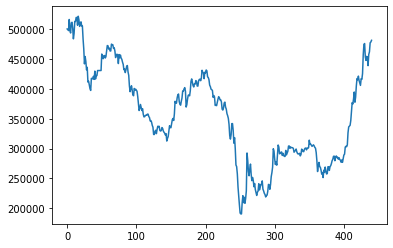

In [34]:
%matplotlib inline
df_account_value.account_value.plot()

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [35]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = BackTestStats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return         -0.021889
Cumulative returns    -0.037990
Annual volatility      0.459591
Sharpe ratio           0.173775
Calmar ratio          -0.034518
Stability              0.327646
Max drawdown          -0.634133
Omega ratio            1.033623
Sortino ratio          0.276953
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.986957
Daily value at risk   -0.057586
Alpha                  0.000000
Beta                   1.000000
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to IHSG===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (430, 8)


Start date,2019-04-02
End date,2021-01-07
Total months,20
,Backtest
Annual return,-3.076%
Cumulative returns,-5.18%
Annual volatility,46.128%
Sharpe ratio,0.15
Calmar ratio,-0.05
Stability,0.44
Max drawdown,-63.413%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,63.41,2019-04-26,2020-04-07,NaT,NaN
1,6.27,2019-04-05,2019-04-15,2019-04-23,13
2,2.49,2019-04-24,2019-04-25,2019-04-26,3
3,0.26,2019-04-02,2019-04-04,2019-04-05,4
4,NaN,NaT,NaT,NaT,NaN


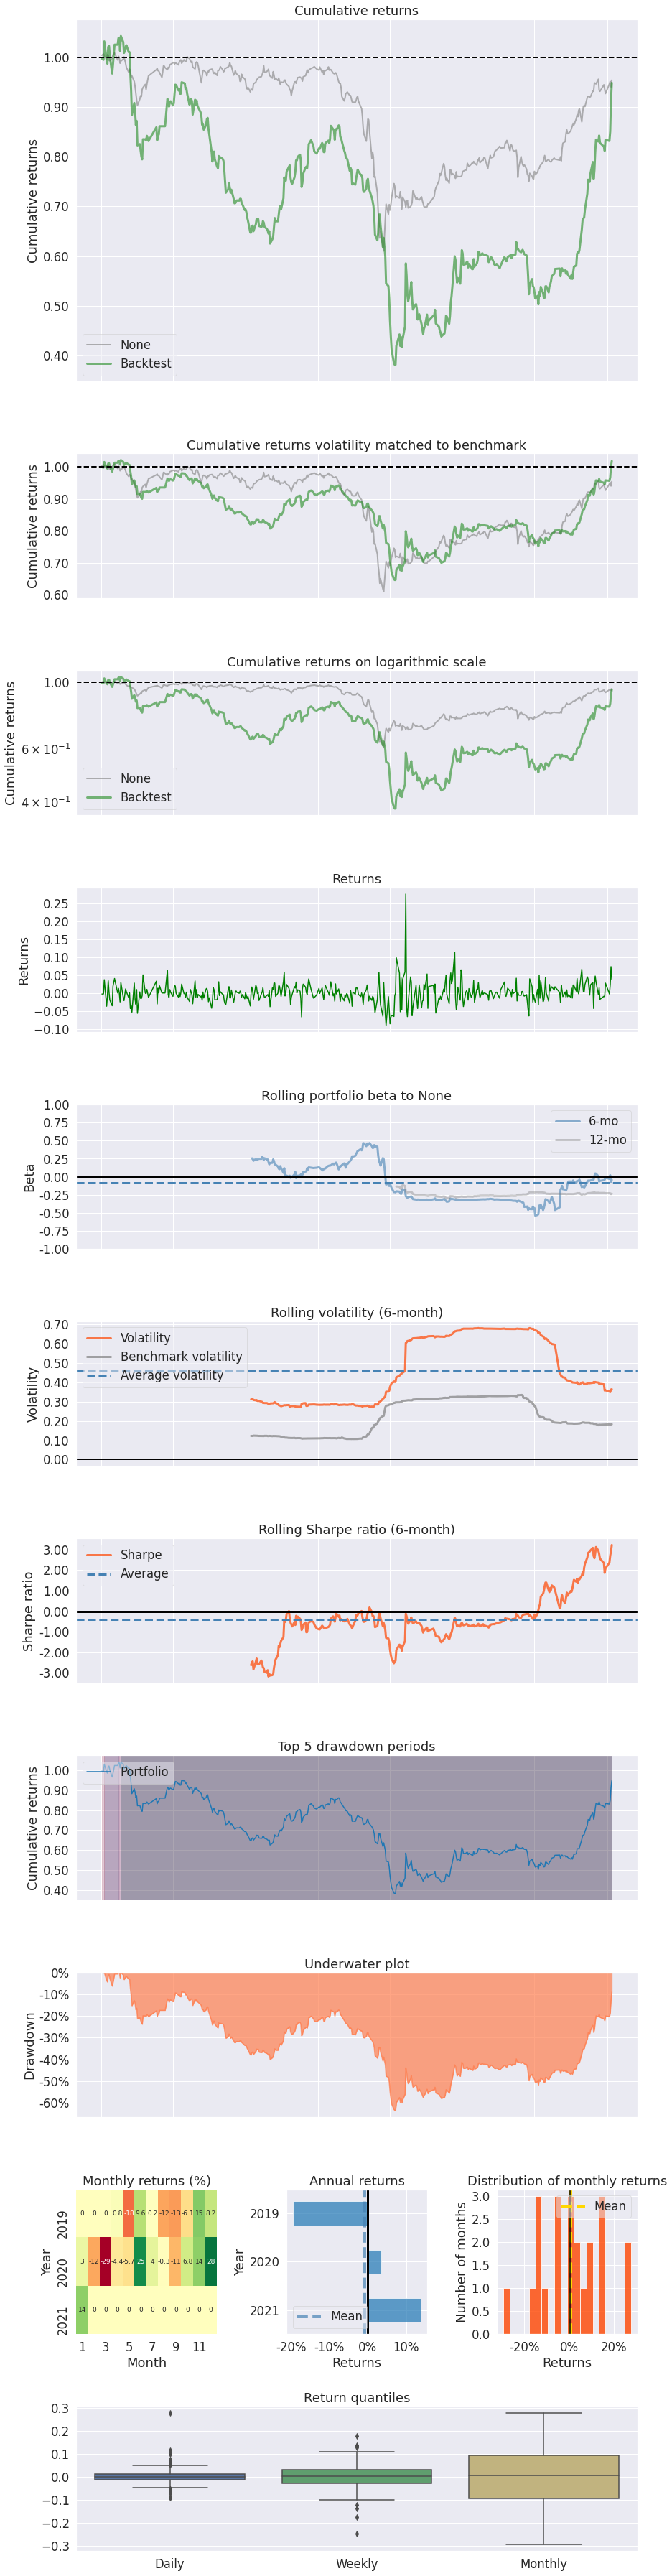

In [36]:
print("==============Compare to IHSG===========")
%matplotlib inline
BackTestPlot(df_account_value, 
             baseline_ticker = '^JKSE', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

<a id='6.3'></a>
## 7.3 Baseline Stats

In [37]:
print("==============Get Baseline Stats===========")
baseline_perf_stats=BaselineStats('^JKSE',
                                  baseline_start = df_account_value.loc[0,'date'],
                                  baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (430, 8)
Annual return         -0.027420
Cumulative returns    -0.046334
Annual volatility      0.216841
Sharpe ratio          -0.020512
Calmar ratio          -0.069439
Stability              0.398216
Max drawdown          -0.394883
Omega ratio            0.996064
Sortino ratio         -0.028793
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.041591
Daily value at risk   -0.027337
Alpha                  0.000000
Beta                   1.000000
dtype: float64
